# **<center><font style="color:rgb(100,109,254)">Introduction to Face Landmarks Detection & Snap Chat Filter with Mediapipe and Python</font> </center>**

<img src='https://google.github.io/mediapipe/images/face_mesh_ar_effects.gif'>


Alright, so without further ado, let's dive in.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

Let's start by importing the required libraries.

In [1]:
import cv2
import itertools
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

As mentioned Mediapipe's face landmarks detection solution internally uses a face detector to get the required Regions of Interest (faces) from the image. So before going to the facial landmarks detection, let's briefly discuss that face detector first, as  Mediapipe also allows to separately use it.

## **<font style="color:rgb(134,19,348)">Face Detection</font>**

The [mediapipe's face detection solution](https://google.github.io/mediapipe/solutions/face_detection.html) is based on [BlazeFace](https://arxiv.org/abs/1907.05047) face detector that uses a very lightweight and highly accurate feature extraction network, that is inspired and modified from [MobileNetV1/V2](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html) and used a detection method similar to [Single Shot MultiBox Detector (SSD)](https://arxiv.org/abs/1512.02325). It is capable of running at a speed of 200-1000+ FPS on flagship devices. For more info, you can check the resources [here](https://google.github.io/mediapipe/solutions/face_detection.html#resources).

### **<font style="color:rgb(134,19,348)">Initialize the Mediapipe Face Detection Model</font>**

To use the Mediapipe's Face Detection solution, we will first have to initialize the face detection class using the syntax **`mp.solutions.face_detection`**, and then we will have to call the function **`mp.solutions.face_detection.FaceDetection()`** with the arguments explained below:


* **`model_selection`** - It is an integer index `( i.e., 0 or 1 )`. When set to `0`, a short-range model is selected that works best for faces within 2 meters from the camera, and when set to `1`, a full-range model is selected that works best for faces within 5 meters. Its default value is `0`.


* **`min_detection_confidence`** - It is the minimum detection confidence between `([0.0, 1.0])` required to consider the face-detection model's prediction successful. Its default value is `0.5` ( i.e., 50% ) which means that all the detections with prediction confidence less than `0.5` are ignored by default. 


We will also have to initialize the drawing class using the syntax **`mp.solutions.drawing_utils`** which is used to visualize the detection results on the images/frames.

In [2]:
# Initialize the mediapipe face detection class.
mp_face_detection = mp.solutions.face_detection

# Setup the face detection function.
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils

### **<font style="color:rgb(134,19,348)">Read an Image</font>**

Now we will use the function [**`cv2.imread()`**](https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56) to read a sample image and then display the image using the [**`matplotlib`**](https://matplotlib.org/stable/index.html) library, after converting it into `RGB` from `BGR` format.

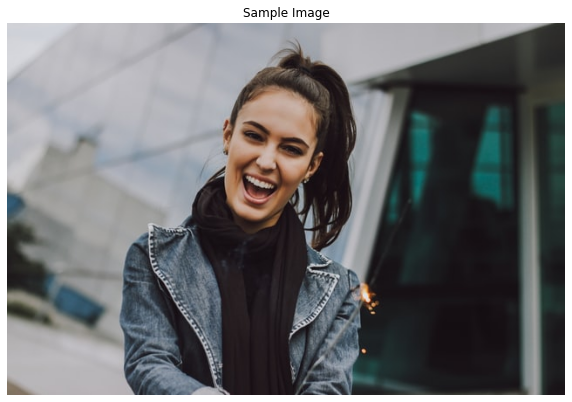

In [3]:
# Read an image from the specified path.
sample_img = cv2.imread('media/sample.jpg')

# Specify a size of the figure.
plt.figure(figsize = [10, 10])

# Display the sample image, also convert BGR to RGB for display. 
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

## **<font style="color:rgb(134,19,348)">Perform Face Detection</font>**

Now to perform the detection on the sample image, we will have to pass the image (in `RGB` format) into the loaded model by using the function **`mp.solutions.face_detection.FaceDetection().process()`** and we will get an object that will have an attribute **`detections`** that contains a list of a bounding box and six key points for each face in the image. The six key points are on the:

1. **Right Eye**
2. **Left Eye**
3. **Nose Tip**
4. **Mouth Center** 
5. **Right Ear Tragion** 
6. **Left Ear Tragion**

After performing the detection, we will display the bounding box coordinates and only the first two key points of each detected face in the image, so that you get more intuition about the format of the output.

In [4]:
# Perform face detection after converting the image into RGB format.
face_detection_results = face_detection.process(sample_img[:,:,::-1])

# Check if the face(s) in the image are found.
if face_detection_results.detections:
    
    # Iterate over the found faces.
    for face_no, face in enumerate(face_detection_results.detections):
        
        # Display the face number upon which we are iterating upon.
        print(f'FACE NUMBER: {face_no+1}')
        print('---------------------------------')
        
        # Display the face confidence.
        print(f'FACE CONFIDENCE: {round(face.score[0], 2)}')
        
        # Get the face bounding box and face key points coordinates.
        face_data = face.location_data
        
        # Display the face bounding box coordinates.
        print(f'\nFACE BOUNDING BOX:\n{face_data.relative_bounding_box}')
        
        # Iterate two times as we only want to display first two key points of each detected face.
        for i in range(2):

            # Display the found normalized key points.
            print(f'{mp_face_detection.FaceKeyPoint(i).name}:')
            print(f'{face_data.relative_keypoints[mp_face_detection.FaceKeyPoint(i).value]}') 

FACE NUMBER: 1
---------------------------------
FACE CONFIDENCE: 0.98

FACE BOUNDING BOX:
xmin: 0.39702364802360535
ymin: 0.2762746810913086
width: 0.16100731492042542
height: 0.24132275581359863

RIGHT_EYE:
x: 0.4368540048599243
y: 0.3198586106300354

LEFT_EYE:
x: 0.5112437605857849
y: 0.3565130829811096



**Note:** *The bounding boxes are composed of `xmin` and `width` (both normalized to `[0.0, 1.0]` by the image width) and `ymin` and `height` (both normalized to `[0.0, 1.0]` by the image height). Each keypoint is composed of `x` and `y`, which are normalized to `[0.0, 1.0]` by the image width and height respectively.*

Now we will draw the detected bounding box(es) and the key points on a copy of the sample image using the function **`mp.solutions.drawing_utils.draw_detection()`** from the class **`mp.solutions.drawing_utils`**, we had initialized earlier and will display the resultant image using the matplotlib library. 

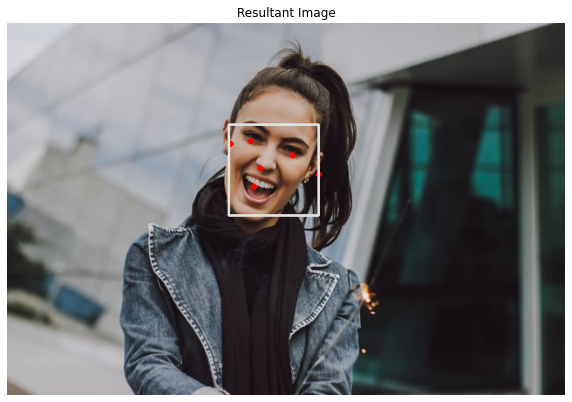

In [5]:
# Create a copy of the sample image to draw the bounding box and key points.
img_copy = sample_img[:,:,::-1].copy()

# Check if the face(s) in the image are found.
if face_detection_results.detections:
    
    # Iterate over the found faces.
    for face_no, face in enumerate(face_detection_results.detections):
        
        # Draw the face bounding box and key points on the copy of the sample image.
        mp_drawing.draw_detection(image=img_copy, detection=face, 
                                 keypoint_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0),
                                                                              thickness=2,
                                                                              circle_radius=2))
# Specify a size of the figure.
fig = plt.figure(figsize = [10, 10])

# Display the resultant image with the bounding box and key points drawn, 
# also convert BGR to RGB for display. 
plt.title("Resultant Image");plt.axis('off');plt.imshow(img_copy);plt.show()

**Note:** *Although, the detector quite accurately detects the faces, but fails to precisely detect facial key points (landmarks) in some scenarios (e.g. for non-frontal, rotated, or occluded faces) so that is why we will need the Mediapipe's face landmarks detection solution for creating the Snapchat filter that is our main goal.* 

## **<font style="color:rgb(134,19,348)">Face Landmarks Detection</font>**

Now, let's move to the facial landmarks detection, we will start by initializing the face landmarks detection model.

### **<font style="color:rgb(134,19,348)">Initialize the Mediapipe Face Landmarks Detection Model</font>**

To initialize the Mediapipe's face landmarks detection model, we will have to initialize the face mesh class using the syntax **`mp.solutions.face_mesh`** and then we will have to call the function **`mp.solutions.face_mesh.FaceMesh()`** with the arguments explained below:

* **`static_image_mode`** - It is a boolean value that is if set to `False`, the solution treats the input images as a video stream. It will try to detect faces in the first input images, and upon a successful detection further localizes the face landmarks. In subsequent images, once all **`max_num_faces`** faces are detected and the corresponding face landmarks are localized, it simply tracks those landmarks without invoking another detection until it loses track of any of the faces. This reduces latency and is ideal for processing video frames. If set to `True`, face detection runs on every input image, ideal for processing a batch of static, possibly unrelated, images. Its default value is `False`.


* **`max_num_faces`** - It is the maximum number of faces to detect. Its default value is `1`.


* **`min_detection_confidence`** - It is the minimum detection confidence `([0.0, 1.0])` required to consider the face-detection model's prediction correct. Its default value is `0.5` which means that all the detections with prediction confidence less than 50% are ignored by default. 


* **`min_tracking_confidence`** - It is the minimum tracking confidence `([0.0, 1.0])` from the landmark-tracking model for the face landmarks to be considered tracked successfully, or otherwise face detection will be invoked automatically on the next input image, so increasing its value increases the robustness, but also increases the latency. It is ignored if **`static_image_mode`** is `True`, where face detection simply runs on every image. Its default value is `0.5`.

After that, we will initialize the **`mp.solutions.drawing_styles`** class that will allow us to get different provided drawing styles of the landmarks on the images/frames.

In [6]:
# Initialize the mediapipe face mesh class.
mp_face_mesh = mp.solutions.face_mesh

# Setup the face landmarks function for images.
face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=2,
                                         min_detection_confidence=0.5)

# Setup the face landmarks function for videos.
face_mesh_videos = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, 
                                         min_detection_confidence=0.5,min_tracking_confidence=0.3)

# Initialize the mediapipe drawing styles class.
mp_drawing_styles = mp.solutions.drawing_styles

## **<font style="color:rgb(134,19,348)">Perform Face Landmarks Detection</font>**

Now to perform the landmarks detection, we will pass the image (in `RGB` format) to the face landmarks detection machine learning pipeline by using the function **`mp.solutions.face_mesh.FaceMesh().process()`** and get a list of **four hundred sixty-eight** facial landmarks for each detected face in the image. Each landmark will have:

* **`x`** - It is the landmark x-coordinate normalized to [0.0, 1.0] by the image width.

* **`y`** - It is the landmark y-coordinate normalized to [0.0, 1.0] by the image height.

* **`z`** - It is the landmark z-coordinate normalized to roughly the same scale as **`x`**. It represents the landmark depth with the center of the head being the origin, and the smaller the value is, the closer the landmark is to the camera. 


We will display only two landmarks of each eye to get an intuition about the format of output, the ml pipeline outputs an object that has an attribute **`multi_face_landmarks`** that contains the found landmarks coordinates of each face as an element of a list.

In [7]:
# Perform face landmarks detection after converting the image into RGB format.
face_mesh_results = face_mesh_images.process(sample_img[:,:,::-1])

# Get the list of indexes of the left and right eye.
LEFT_EYE_INDEXES = list(set(itertools.chain(*mp_face_mesh.FACEMESH_LEFT_EYE)))
RIGHT_EYE_INDEXES = list(set(itertools.chain(*mp_face_mesh.FACEMESH_RIGHT_EYE)))

# Check if facial landmarks are found.
if face_mesh_results.multi_face_landmarks:
    
    # Iterate over the found faces.
    for face_no, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):
        
        # Display the face number upon which we are iterating upon.
        print(f'FACE NUMBER: {face_no+1}')
        print('-----------------------')
        
        # Display the face part name i.e., left eye whose landmarks we are gonna display.
        print(f'LEFT EYE LANDMARKS:\n')
        
        # Iterate over the first two landmarks indexes of the left eye.
        for LEFT_EYE_INDEX in LEFT_EYE_INDEXES[:2]:
            
            # Display the found normalized landmarks of the left eye.
            print(face_landmarks.landmark[LEFT_EYE_INDEX])
        
        # Display the face part name i.e., right eye whose landmarks we are gonna display.
        print(f'RIGHT EYE LANDMARKS:\n')
        
        # Iterate over the first two landmarks indexes of the right eye.
        for RIGHT_EYE_INDEX in RIGHT_EYE_INDEXES[:2]:
            
            # Display the found normalized landmarks of the right eye.
            print(face_landmarks.landmark[RIGHT_EYE_INDEX])

FACE NUMBER: 1
-----------------------
LEFT EYE LANDMARKS:

x: 0.49976223707199097
y: 0.33403876423835754
z: -0.003551195142790675

x: 0.505622386932373
y: 0.3346547782421112
z: -0.005253524519503117

RIGHT EYE LANDMARKS:

x: 0.4383928179740906
y: 0.29986220598220825
z: -0.001492970623075962

x: 0.43043234944343567
y: 0.3003302812576294
z: 0.006076945923268795



**Note:** *The z-coordinate is just the relative distance of the landmark from the center of the head, and this distance increases and decreases depending upon the distance from the camera so that is why it represents the depth of each landmark point.*

Now we will draw the detected landmarks on a copy of the sample image using the function **`mp.solutions.drawing_utils.draw_landmarks()`** from the class **`mp.solutions.drawing_utils`**, we had initialized earlier and will display the resultant image. The function **`mp.solutions.drawing_utils.draw_landmarks()`** can take the following arguments.

* **`image`** - It is the image in RGB format on which the landmarks are to be drawn.


* **`landmark_list`** - It is the normalized landmark list that is to be drawn on the image.


*  **`connections`** - It is the list of landmark index tuples that specifies how landmarks to be connected in the drawing. The provided options are; `mp_face_mesh.FACEMESH_FACE_OVAL, mp_face_mesh.FACEMESH_LEFT_EYE, mp_face_mesh.FACEMESH_LEFT_EYEBROW, mp_face_mesh.FACEMESH_LIPS, mp_face_mesh.FACEMESH_RIGHT_EYE, mp_face_mesh.FACEMESH_RIGHT_EYEBROW, mp_face_mesh.FACEMESH_TESSELATION, mp_face_mesh.FACEMESH_CONTOURS`.
    
    
*  **`landmark_drawing_spec`** - It specifies the landmarks' drawing settings such as color, line thickness, and circle radius. It can be set equal to the `mp.solutions.drawing_utils.DrawingSpec(color, thickness, circle_radius))` object.


*  **`connection_drawing_spec`** - It specifies the connections' drawing settings such as color and line thickness. It can be either a `mp.solutions.drawing_utils.DrawingSpec` object or a function from the class `mp.solutions.drawing_styles`, the currently provided options for face mesh are; `get_default_face_mesh_contours_style()` ,`get_default_face_mesh_tesselation_style()`.

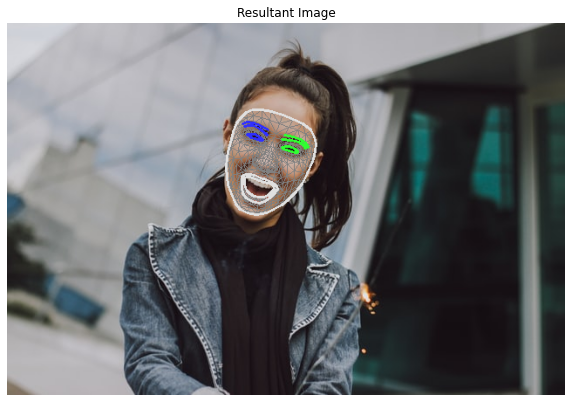

In [8]:
# Create a copy of the sample image in RGB format to draw the found facial landmarks on.
img_copy = sample_img[:,:,::-1].copy()

# Check if facial landmarks are found.
if face_mesh_results.multi_face_landmarks:
    
    # Iterate over the found faces.
    for face_landmarks in face_mesh_results.multi_face_landmarks:
        
        # Draw the facial landmarks on the copy of the sample image with the
        # face mesh tesselation connections using default face mesh tesselation style.
        mp_drawing.draw_landmarks(image=img_copy, 
                                  landmark_list=face_landmarks,connections=mp_face_mesh.FACEMESH_TESSELATION,
                                  landmark_drawing_spec=None, 
                                  connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
        
        # Draw the facial landmarks on the copy of the sample image with the
        # face mesh contours connections using default face mesh contours style.
        mp_drawing.draw_landmarks(image=img_copy, landmark_list=face_landmarks,connections=mp_face_mesh.FACEMESH_CONTOURS,
                                  landmark_drawing_spec=None, 
                                  connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
        
# Specify a size of the figure.
fig = plt.figure(figsize = [10, 10])

# Display the resultant image with the face mesh drawn. 
plt.title("Resultant Image");plt.axis('off');plt.imshow(img_copy);plt.show()

### **<font style="color:rgb(134,19,348)">Create a Face Landmarks Detection Function</font>**

Now we will put all this together to create a function **`detectFacialLandmarks()`** that will perform face landmarks detection on an image and will visualize the resultant image along with the original image or return the resultant image along with the output of the model depending upon the passed arguments.

In [9]:
def detectFacialLandmarks(image, face_mesh, display = True):
    '''
    This function performs facial landmarks detection on an image.
    Args:
        image:     The input image of person(s) whose facial landmarks needs to be detected.
        face_mesh: The face landmarks detection function required to perform the landmarks detection.
        display:   A boolean value that is if set to true the function displays the original input image, 
                   and the output image with the face landmarks drawn and returns nothing.
    Returns:
        output_image: A copy of input image with face landmarks drawn.
        results:      The output of the facial landmarks detection on the input image.
    '''
    
    # Perform the facial landmarks detection on the image, after converting it into RGB format.
    results = face_mesh.process(image[:,:,::-1])
    
    # Create a copy of the input image to draw facial landmarks.
    output_image = image[:,:,::-1].copy()
    
    # Check if facial landmarks in the image are found.
    if results.multi_face_landmarks:

        # Iterate over the found faces.
        for face_landmarks in results.multi_face_landmarks:

            # Draw the facial landmarks on the output image with the face mesh tesselation
            # connections using default face mesh tesselation style.
            mp_drawing.draw_landmarks(image=output_image, landmark_list=face_landmarks,
                                      connections=mp_face_mesh.FACEMESH_TESSELATION,
                                      landmark_drawing_spec=None, 
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())

            # Draw the facial landmarks on the output image with the face mesh contours
            # connections using default face mesh contours style.
            mp_drawing.draw_landmarks(image=output_image, landmark_list=face_landmarks,
                                      connections=mp_face_mesh.FACEMESH_CONTOURS,
                                      landmark_drawing_spec=None, 
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())

    # Check if the original input image and the output image are specified to be displayed.
    if display:
        
        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image);plt.title("Output");plt.axis('off');
        
    # Otherwise
    else:
        
        # Return the output image in BGR format and results of facial landmarks detection.
        return np.ascontiguousarray(output_image[:,:,::-1], dtype=np.uint8), results              

Now we will utilize the function **`detectFacialLandmarks()`** created above to perform face landmarks detection on a few sample images and display the results.

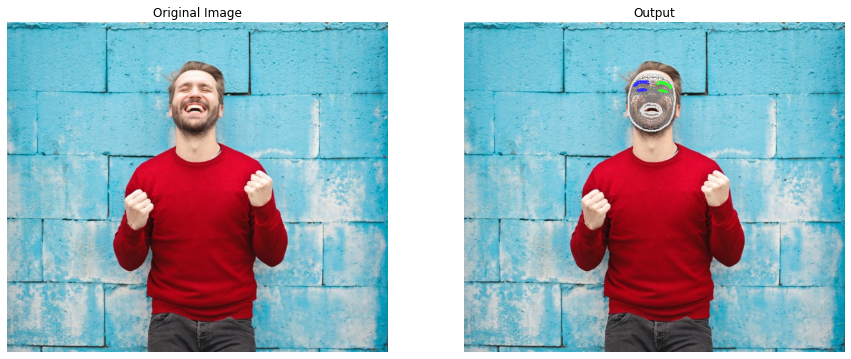

In [10]:
# Read a sample image and perform facial landmarks detection on it.
image = cv2.imread('media/sample1.jpg')
detectFacialLandmarks(image, face_mesh_images, display=True)

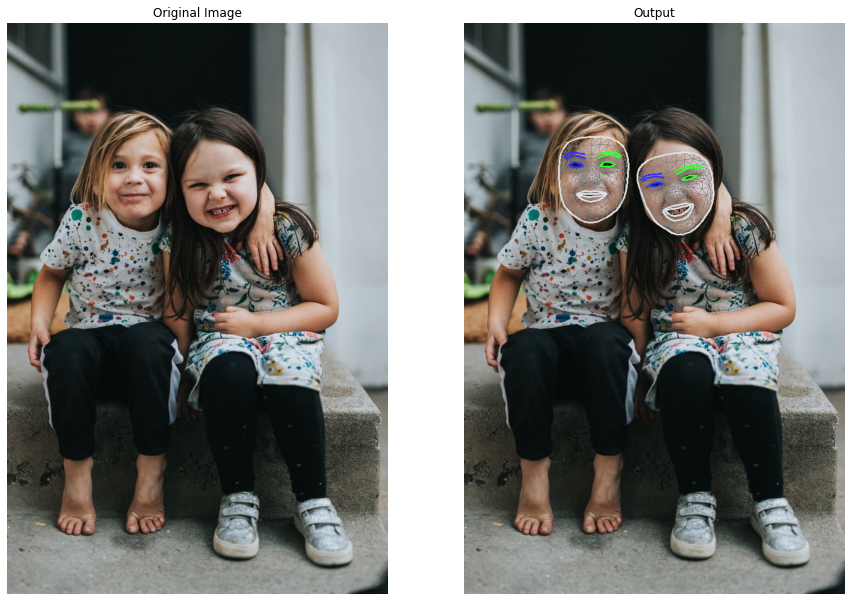

In [11]:
# Read another sample image and perform facial landmarks detection on it.
image = cv2.imread('media/sample2.jpg')
detectFacialLandmarks(image, face_mesh_images, display=True)

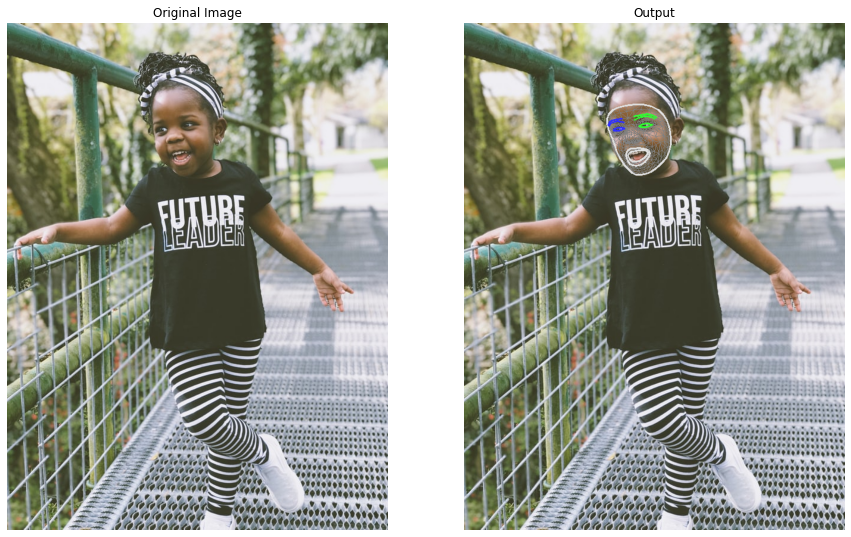

In [12]:
# Read another sample image and perform facial landmarks detection on it.
image = cv2.imread('media/sample3.jpg')
detectFacialLandmarks(image, face_mesh_images, display=True)

### **<font style="color:rgb(134,19,348)">Face Landmarks Detection on Real-Time Webcam Feed</font>**

The results on the images were remarkable, but now we will try the function on a real-time webcam feed. We will also calculate and display the number of frames being updated in one second to get an idea of whether this solution can work in real-time on a CPU or not.

In [13]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Face Landmarks Detection', cv2.WINDOW_NORMAL)

# Initialize a variable to store the time of the previous frame.
time1 = 0

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to 
    # read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Perform Face landmarks detection.
    frame, _ = detectFacialLandmarks(frame, face_mesh_videos, display=False)
    
    # Set the time for this frame to the current time.
    time2 = time()
    
    # Check if the difference between the previous and this frame time > 0 to avoid 
    # division by zero.
    if (time2 - time1) > 0:
    
        # Calculate the number of frames per second.
        frames_per_second = 1.0 / (time2 - time1)
        
        # Write the calculated number of frames per second on the frame. 
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),
                    cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    # Update the previous frame time to this frame time.
    # As this frame will become previous frame in next iteration.
    time1 = time2
    
    # Display the frame.
    cv2.imshow('Face Landmarks Detection', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF    
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.                  
camera_video.release()
cv2.destroyAllWindows()

Impressive! the solution is fast as well as accurate.

## **<font style="color:rgb(134,19,348)">Face Expression Recognition</font>**

Now that we have the detected landmarks, we will use them to recognize the facial expressions of people in the images/videos using the classical techniques. Our recognizor will be capable of identifying the following facial expressions:

* **Eyes Opened or Closed** 😳 (*can be used to check <font style="color:rgb(255,140,0)"> **drowsiness**</font>, <font style="color:rgb(255,140,0)">**wink**</font>  or <font style="color:rgb(255,140,0)">**shock expression**</font>*)

* **Mouth Opened or Closed** 😱 (*can be used to check <font style="color:rgb(255,140,0)">**yawning**</font>*)

For the sake of simplicity, we are only limiting this to two expressions. But if you want, you can easily extend this application to make it capable of identifying more facial expressions just by adding more conditional statements or maybe merging these two conditions. Like for example, eyes and mouth both wide open can represent <font style="color:rgb(255,140,0)">**surprise**</font> expression.

### **<font style="color:rgb(134,19,348)">Create a Function to Calculate Size of a Face Part</font>**

First, we will create a function **`getSize()`** that will utilize detected landmarks to calculate the size of a face part. All we will need is to figure out a way to isolate the landmarks of the face part and luckily that can easily be done using the frozenset objects (attributes of the  **`mp.solutions.face_mesh`** class), which contain the required indexes.


* **`mp_face_mesh.FACEMESH_FACE_OVAL`** contains indexes of <font style="color:rgb(0,200,0)">**face outline**</font>.
</center>

* **`mp_face_mesh.FACEMESH_LIPS`** contains indexes of <font style="color:rgb(0,200,0)">**lips**</font>.

* **`mp_face_mesh.FACEMESH_LEFT_EYE`** contains indexes of <font style="color:rgb(0,200,0)">**left eye**</font>.

* **`mp_face_mesh.FACEMESH_RIGHT_EYE`** contains indexes of <font style="color:rgb(0,200,0)">**right eye**</font>.

* **`mp_face_mesh.FACEMESH_LEFT_EYEBROW`** contains indexes of <font style="color:rgb(0,200,0)">**left eyebrow**</font>.

* **`mp_face_mesh.FACEMESH_RIGHT_EYEBROW`** contains indexes of <font style="color:rgb(0,200,0)">**right eyebrow**</font>.

After retrieving the landmarks of the face part, we will simply pass it to the function [**`cv2.boundingRect()`**](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#ga103fcbda2f540f3ef1c042d6a9b35ac7) to get the width and height of the face part. The function **`cv2.boundingRect(landmarks)`** returns the coordinates **(`x1`, `y1`, `width`, `height`)** of a bounding box enclosing the object (face part), given the landmarks but we will only need the **`height`** and **`width`** of the bounding box.

In [14]:
def getSize(image, face_landmarks, INDEXES):
    '''
    This function calculate the height and width of a face part utilizing its landmarks.
    Args:
        image:          The image of person(s) whose face part size is to be calculated.
        face_landmarks: The detected face landmarks of the person whose face part size is to 
                        be calculated.
        INDEXES:        The indexes of the face part landmarks, whose size is to be calculated.
    Returns:
        width:     The calculated width of the face part of the face whose landmarks were passed.
        height:    The calculated height of the face part of the face whose landmarks were passed.
        landmarks: An array of landmarks of the face part whose size is calculated.
    '''
    
    # Retrieve the height and width of the image.
    image_height, image_width, _ = image.shape
    
    # Convert the indexes of the landmarks of the face part into a list.
    INDEXES_LIST = list(itertools.chain(*INDEXES))
    
    # Initialize a list to store the landmarks of the face part.
    landmarks = []
    
    # Iterate over the indexes of the landmarks of the face part. 
    for INDEX in INDEXES_LIST:
        
        # Append the landmark into the list.
        landmarks.append([int(face_landmarks.landmark[INDEX].x * image_width),
                               int(face_landmarks.landmark[INDEX].y * image_height)])
    
    # Calculate the width and height of the face part.
    _, _, width, height = cv2.boundingRect(np.array(landmarks))
    
    # Convert the list of landmarks of the face part into a numpy array.
    landmarks = np.array(landmarks)
    
    # Retrurn the calculated width height and the landmarks of the face part.
    return width, height, landmarks

Now we will create a function **`isOpen()`** that will utilize the **`getSize()`** function we had created above to check whether a face part (e.g. mouth or an eye) of a person is opened or closed.

<img src='https://drive.google.com/uc?export=download&id=1RB1ToEHrvvVmIHdxSwwKWcw9190lnBcA' width=300>

**Hint:** *The height of an opened mouth or eye will be greater than the height of a closed mouth or eye.*

In [15]:
def isOpen(image, face_mesh_results, face_part, threshold=5, display=True):
    '''
    This function checks whether the an eye or mouth of the person(s) is open, 
    utilizing its facial landmarks.
    Args:
        image:             The image of person(s) whose an eye or mouth is to be checked.
        face_mesh_results: The output of the facial landmarks detection on the image.
        face_part:         The name of the face part that is required to check.
        threshold:         The threshold value used to check the isOpen condition.
        display:           A boolean value that is if set to true the function displays 
                           the output image and returns nothing.
    Returns:
        output_image: The image of the person with the face part is opened  or not status written.
        status:       A dictionary containing isOpen statuses of the face part of all the 
                      detected faces.  
    '''
    
    # Retrieve the height and width of the image.
    image_height, image_width, _ = image.shape
    
    # Create a copy of the input image to write the isOpen status.
    output_image = image.copy()
    
    # Create a dictionary to store the isOpen status of the face part of all the detected faces.
    status={}
    
    # Check if the face part is mouth.
    if face_part == 'MOUTH':
        
        # Get the indexes of the mouth.
        INDEXES = mp_face_mesh.FACEMESH_LIPS
        
        # Specify the location to write the is mouth open status.
        loc = (10, image_height - image_height//40)
        
        # Initialize a increment that will be added to the status writing location, 
        # so that the statuses of two faces donot overlap. 
        increment=-30
        
    # Check if the face part is left eye.    
    elif face_part == 'LEFT EYE':
        
        # Get the indexes of the left eye.
        INDEXES = mp_face_mesh.FACEMESH_LEFT_EYE
        
        # Specify the location to write the is left eye open status.
        loc = (10, 30)
        
        # Initialize a increment that will be added to the status writing location, 
        # so that the statuses of two faces donot overlap.
        increment=30
    
    # Check if the face part is right eye.    
    elif face_part == 'RIGHT EYE':
        
        # Get the indexes of the right eye.
        INDEXES = mp_face_mesh.FACEMESH_RIGHT_EYE 
        
        # Specify the location to write the is right eye open status.
        loc = (image_width-300, 30)
        
        # Initialize a increment that will be added to the status writing location, 
        # so that the statuses of two faces donot overlap.
        increment=30
    
    # Otherwise return nothing.
    else:
        return
    
    # Iterate over the found faces.
    for face_no, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):
        
         # Get the height of the face part.
        _, height, _ = getSize(image, face_landmarks, INDEXES)
        
         # Get the height of the whole face.
        _, face_height, _ = getSize(image, face_landmarks, mp_face_mesh.FACEMESH_FACE_OVAL)
        
        # Check if the face part is open.
        if (height/face_height)*100 > threshold:
            
            # Set status of the face part to open.
            status[face_no] = 'OPEN'
            
            # Set color which will be used to write the status to green.
            color=(0,255,0)
        
        # Otherwise.
        else:
            # Set status of the face part to close.
            status[face_no] = 'CLOSE'
            
            # Set color which will be used to write the status to red.
            color=(0,0,255)
        
        # Write the face part isOpen status on the output image at the appropriate location.
        cv2.putText(output_image, f'FACE {face_no+1} {face_part} {status[face_no]}.', 
                    (loc[0],loc[1]+(face_no*increment)), cv2.FONT_HERSHEY_PLAIN, 1.4, color, 2)
                
    # Check if the output image is specified to be displayed.
    if display:

        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:
        
        # Return the output image and the isOpen statuses of the face part of each detected face.
        return output_image, status

Now we will utilize the function **`isOpen()`** created above to check the mouth and eyes status on a few sample images and display the results.

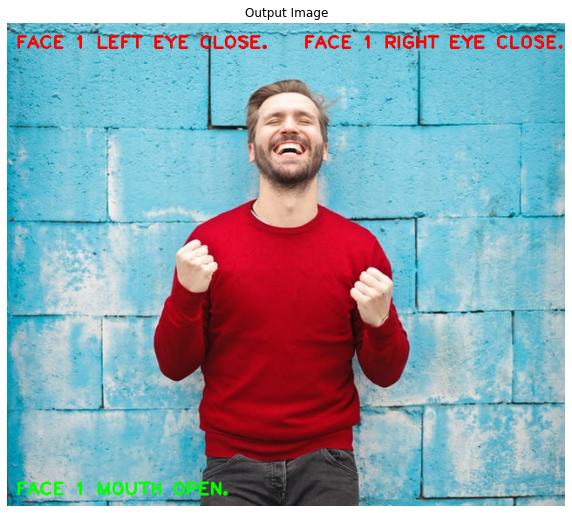

In [16]:
# Read another sample image and perform facial expression recognition on it.
image = cv2.imread('media/sample1.jpg')
image = cv2.flip(image, 1)
_, face_mesh_results = detectFacialLandmarks(image, face_mesh_images, display=False)
if face_mesh_results.multi_face_landmarks:
    output_image, _ = isOpen(image, face_mesh_results, 'MOUTH', threshold=15, display=False)
    output_image, _ = isOpen(output_image, face_mesh_results, 'LEFT EYE', threshold=5, display=False)
    isOpen(output_image, face_mesh_results, 'RIGHT EYE', threshold=5)

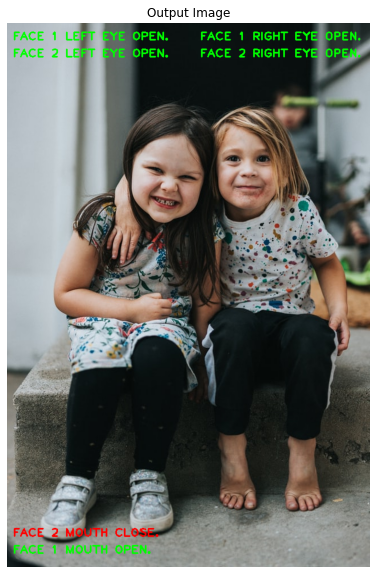

In [17]:
# Read another sample image and perform facial expression recognition on it.
image = cv2.imread('media/sample2.jpg')
image = cv2.flip(image, 1)
_, face_mesh_results = detectFacialLandmarks(image, face_mesh_images, display=False)
if face_mesh_results.multi_face_landmarks:
    output_image, _ = isOpen(image, face_mesh_results, 'MOUTH', threshold=15, display=False)
    output_image, _ = isOpen(output_image, face_mesh_results, 'LEFT EYE', threshold=5, display=False)
    isOpen(output_image, face_mesh_results, 'RIGHT EYE', threshold=5)

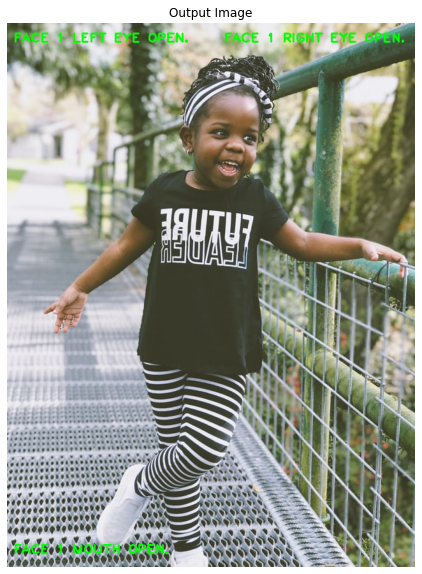

In [18]:
# Read another sample image and perform facial expression recognition on it.
image = cv2.imread('media/sample3.jpg')
image = cv2.flip(image, 1)
_, face_mesh_results = detectFacialLandmarks(image, face_mesh_images, display=False)
if face_mesh_results.multi_face_landmarks:
    output_image, _ = isOpen(image, face_mesh_results, 'MOUTH', threshold=15, display=False)
    output_image, _ = isOpen(output_image, face_mesh_results, 'LEFT EYE', threshold=5, display=False)
    isOpen(output_image, face_mesh_results, 'RIGHT EYE', threshold=5)

As expected, the results are fascinating!

## **<font style="color:rgb(134,19,348)">Snapchat Filter Controlled by Facial Expressions</font>**

Now that we have the face expression recognizer, let's start building a Snapchat filter on top of it, that will be triggered based on the facial expressions of the person in real-time. 

Currently, our face expression recognizer can check whether the eyes and mouth are open `😯` or not `😌` so to get the most out of it, we can overlay scalable eyes `👀` images on top of the eyes of the user when his eyes are open and a video of fire `🔥`  coming out of the mouth of the user when the mouth is open.

<img src='https://drive.google.com/uc?export=download&id=1eVhSoBBXmIdhYRgqx9bRXfIco-zuiqcX'>


### **<font style="color:rgb(134,19,348)">Create a Function to Overlay the Image Filters</font>**

Now we will create a function **`overlay()`** that will apply the filters on top of the eyes and mouth of a person in images/videos utilizing the facial landmarks to locate the face parts and will also resize the filter images according to the size of the face part on which the filter images will be overlayed.

<img src='https://drive.google.com/uc?export=download&id=1-aauJnn8h5WMJ2KSO4CCSBnvGdgBQr4r'>

In [19]:
def overlay(image, filter_img, face_landmarks, face_part, INDEXES, display=True):
    '''
    This function will overlay a filter image over a face part of a person in the image/frame.
    Args:
        image:          The image of a person on which the filter image will be overlayed.
        filter_img:     The filter image that is needed to be overlayed on the image of the person.
        face_landmarks: The facial landmarks of the person in the image.
        face_part:      The name of the face part on which the filter image will be overlayed.
        INDEXES:        The indexes of landmarks of the face part.
        display:        A boolean value that is if set to true the function displays 
                        the annotated image and returns nothing.
    Returns:
        annotated_image: The image with the overlayed filter on the top of the specified face part.
    '''
    
    # Create a copy of the image to overlay filter image on.
    annotated_image = image.copy()
    
    # Errors can come when it resizes the filter image to a too small or a too large size .
    # So use a try block to avoid application crashing.
    try:
    
        # Get the width and height of filter image.
        filter_img_height, filter_img_width, _  = filter_img.shape

        # Get the height of the face part on which we will overlay the filter image.
        _, face_part_height, landmarks = getSize(image, face_landmarks, INDEXES)
        
        # Specify the height to which the filter image is required to be resized.
        required_height = int(face_part_height*2.5)
        
        # Resize the filter image to the required height, while keeping the aspect ratio constant. 
        resized_filter_img = cv2.resize(filter_img, (int(filter_img_width*
                                                         (required_height/filter_img_height)),
                                                     required_height))
        
        # Get the new width and height of filter image.
        filter_img_height, filter_img_width, _  = resized_filter_img.shape

        # Convert the image to grayscale and apply the threshold to get the mask image.
        _, filter_img_mask = cv2.threshold(cv2.cvtColor(resized_filter_img, cv2.COLOR_BGR2GRAY),
                                           25, 255, cv2.THRESH_BINARY_INV)

        # Calculate the center of the face part.
        center = landmarks.mean(axis=0).astype("int")

        # Check if the face part is mouth.
        if face_part == 'MOUTH':

            # Calculate the location where the smoke filter will be placed.  
            location = (int(center[0] - filter_img_width / 3), int(center[1]))

        # Otherwise if the face part is an eye.
        else:

            # Calculate the location where the eye filter image will be placed.  
            location = (int(center[0]-filter_img_width/2), int(center[1]-filter_img_height/2))

        # Retrieve the region of interest from the image where the filter image will be placed.
        ROI = image[location[1]: location[1] + filter_img_height,
                    location[0]: location[0] + filter_img_width]

        # Perform Bitwise-AND operation. This will set the pixel values of the region where,
        # filter image will be placed to zero.
        resultant_image = cv2.bitwise_and(ROI, ROI, mask=filter_img_mask)

        # Add the resultant image and the resized filter image.
        # This will update the pixel values of the resultant image at the indexes where 
        # pixel values are zero, to the pixel values of the filter image.
        resultant_image = cv2.add(resultant_image, resized_filter_img)

        # Update the image's region of interest with resultant image.
        annotated_image[location[1]: location[1] + filter_img_height,
                        location[0]: location[0] + filter_img_width] = resultant_image
            
    # Catch and handle the error(s).
    except Exception as e:
        pass
    
    # Check if the annotated image is specified to be displayed.
    if display:

        # Display the annotated image.
        plt.figure(figsize=[10,10])
        plt.imshow(annotated_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:
            
        # Return the annotated image.
        return annotated_image

### **<font style="color:rgb(134,19,348)">Snapchat Filter on Real-Time Webcam Feed</font>**

Now we will utilize the function **`overlay()`** created above to apply filters based on the facial expressions, that we will recognize utilizing the function **`isOpen()`** on a real-time webcam feed.

In [20]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Face Filter', cv2.WINDOW_NORMAL)

# Read the left and right eyes images.
left_eye = cv2.imread('media/left_eye.png')
right_eye = cv2.imread('media/right_eye.png')

# Initialize the VideoCapture object to read from the smoke animation video stored in the disk.
smoke_animation = cv2.VideoCapture('media/smoke_animation.mp4')

# Set the smoke animation video frame counter to zero.
smoke_frame_counter = 0

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read
    # the next frame.
    if not ok:
        continue
        
    # Read a frame from smoke animation video
    _, smoke_frame = smoke_animation.read()
    
    # Increment the smoke animation video frame counter.
    smoke_frame_counter += 1
    
    # Check if the current frame is the last frame of the smoke animation video.
    if smoke_frame_counter == smoke_animation.get(cv2.CAP_PROP_FRAME_COUNT):     
        
        # Set the current frame position to first frame to restart the video.
        smoke_animation.set(cv2.CAP_PROP_POS_FRAMES, 0)
        
        # Set the smoke animation video frame counter to zero.
        smoke_frame_counter = 0
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Perform Face landmarks detection.
    _, face_mesh_results = detectFacialLandmarks(frame, face_mesh_videos, display=False)
    
    # Check if facial landmarks are found.
    if face_mesh_results.multi_face_landmarks:
        
        # Get the mouth isOpen status of the person in the frame.
        _, mouth_status = isOpen(frame, face_mesh_results, 'MOUTH', 
                                     threshold=15, display=False)
        
        # Get the left eye isOpen status of the person in the frame.
        _, left_eye_status = isOpen(frame, face_mesh_results, 'LEFT EYE', 
                                        threshold=4.5 , display=False)
        
        # Get the right eye isOpen status of the person in the frame.
        _, right_eye_status = isOpen(frame, face_mesh_results, 'RIGHT EYE', 
                                         threshold=4.5, display=False)
        
        # Iterate over the found faces.
        for face_num, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):
            
            # Check if the left eye of the face is open.
            if left_eye_status[face_num] == 'OPEN':
                
                # Overlay the left eye image on the frame at the appropriate location.
                frame = overlay(frame, left_eye, face_landmarks,
                                'LEFT EYE', mp_face_mesh.FACEMESH_LEFT_EYE, display=False)
            
            # Check if the right eye of the face is open.
            if right_eye_status[face_num] == 'OPEN':
                
                # Overlay the right eye image on the frame at the appropriate location.
                frame = overlay(frame, right_eye, face_landmarks,
                                'RIGHT EYE', mp_face_mesh.FACEMESH_RIGHT_EYE, display=False)
            
            # Check if the mouth of the face is open.
            if mouth_status[face_num] == 'OPEN':
                
                # Overlay the smoke animation on the frame at the appropriate location.
                frame = overlay(frame, smoke_frame, face_landmarks, 
                                'MOUTH', mp_face_mesh.FACEMESH_LIPS, display=False)
    
    # Display the frame.
    cv2.imshow('Face Filter', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF    
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.                  
camera_video.release()
cv2.destroyAllWindows()

Cool! I am impressed by the results now if you want, you can extend the application and add more filters like glasses, nose, and ears, etc. and use some other facial expressions to trigger those filters.

#  <center> <font style="color:rgb(234,19,148)">Join My Computer Vision Cutting Edge Applications Course</font>   </center>

You can now join the waitlist for my brand new upcoming course on building cutting edge applications, I’m not going into any details now but I’m just going to say this course will be a Blast, to say the least. This will be a completely application-oriented course and it will train you on how to create State of the Art exciting applications.

<img src='https://drive.google.com/uc?export=download&id=1GYO8Rg6l1ClLmEtPQz7Mwve-aSt9vvId'>

<br>
<br>

<center>  <a href="https://app.monstercampaigns.com/c/iczxplyvbomkeyzm0jew/"> <button>Join Now!</button>
</a></center>
    
